# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
# CHeckout this reference this reference(important) : -
#https://medium.com/@1522933668924/using-matplotlib-in-jupyter-notebooks-comparing-methods-and-some-tips-python-c38e85b40ba1

%matplotlib inline
#Use %matplotlibe inline - this only draws the images, not interactive / zoom-able but it works well.

import warnings
#This is the base class of all warning category classes. It is a subclass of Exception.

warnings.filterwarnings("ignore")
# ignore all the warning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3  # For forming connection between the code and sql
import time

## [1] Reading Data

In [2]:
connection = sqlite3.connect('/home/kushagra/Desktop/Excercise/reviews_dataset/database.sqlite')
data = pd.read_sql_query('''SELECT*FROM Reviews where score != 3 LIMIT 5000''',connection)
# Our
def positive_negative(x):
    if x<3:
        return 0
    return 1

filter_data = data['Score'].map(positive_negative)
data['Score'] = filter_data
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [3]:
# SQL Query for Total Number of users i.e. unique userid's
unique = pd.read_sql_query('''SELECT *,COUNT(*) FROM Reviews GROUP BY UserId HAVING COUNT(*)>1''',connection)
#group by Groups together same UserId's, used with count
unique.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,COUNT(*)
0,83318,B005ZBZLT4,#oc-R115TNMSPFT9I7,Breyton,2,3,2,1331510400,"""Green"" K-cup packaging sacrifices flavor",Overall its just OK when considering the price...,2
1,290948,B005HG9ESG,#oc-R11D9D7SHXIJB9,"Louis E. Emory ""hoppy""",0,0,5,1342396800,Muscle spasms,"My wife has recurring extreme muscle spasms, u...",3
2,83657,B005ZBZLT4,#oc-R11DNU2NBKQ23Z,Kim Cieszykowski,0,2,1,1348531200,Terrible coffee,This coffee is horrible and unfortunately not ...,2
3,290774,B005HG9ESG,#oc-R11O5J5ZVQE25C,Penguin Chick,0,0,5,1346889600,Refreshing!,This will be the bottle that you grab from the...,3
4,181479,B007OSBEV0,#oc-R12KPBODL2B5ZD,Christopher P. Presta,5,8,1,1348617600,Not what I expected,I didnt like this coffee. Instead of telling y...,2


In [4]:
print('Total number of user = ' ,unique.shape[0]) #Total Number of users i.e. unique userid's
print('Total number of reviews' ,unique['COUNT(*)'].sum())  # Total number of reviews
print("Average review per person = ", unique['COUNT(*)'].sum()/unique.shape[0])

Total number of user =  80668
Total number of reviews 393063
Average review per person =  4.872601279317697


#  Exploratory Data Analysis

## [2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [5]:
x = pd.read_sql_query('''select * from Reviews where UserId = "AR5J8UI46CURR"''',connection)
x
# As you can see there is redundancy.
# This redundancy is due to the fact that one product has many variations for eg:-
# A speaker of same model might have different colors, they will share the same review. Hence this redundancy.
# We need to remove this redundancy because we don't want our data to be baised.
# There might be more other redundancy, you need to figure these redundacy on you own.

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that 

ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)

ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [6]:
# There is another type of redundancy. i.e. HelpfulnessNumerator cannot be greater than HelpfulnessDenominator
x = pd.read_sql_query('''select * from Reviews Where "HelpfulnessNumerator">"HelpfulnessDenominator"''',connection)
x

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...
1,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...


In [7]:
# Need to remove the redundancy discovered above
# Before we remove the redundancy we need to sort the data, then we can use pandas inbuit fn to remove redundancy
# Removing redundancy on sorted data will be faster# Our
sorted_data = data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort',na_position='last') #na_position is the position of NaN data
sorted_data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
2546,2774,B00002NCJC,A196AJHU9EASJN,Alex Chaffee,0,0,1,1282953600,thirty bucks?,Why is this $[...] when the same product is av...
2547,2775,B00002NCJC,A13RRPGE79XFFH,reader48,0,0,1,1281052800,Flies Begone,We have used the Victor fly bait for 3 seasons...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,1,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,1,961718400,Great Product,This was a really good idea and the final prod...
2942,3204,B000084DVR,A1UGDJP1ZJWVPF,"T. Moore ""thoughtful reader""",1,1,1,1177977600,Good stuff!,I'm glad my 45lb cocker/standard poodle puppy ...


In [8]:
non_redundant = sorted_data.drop_duplicates(subset={"UserId","Time","ProfileName","Text"},keep='first')
non_redundant = non_redundant[non_redundant['HelpfulnessNumerator']<=non_redundant['HelpfulnessDenominator']]

In [9]:
print(non_redundant.shape)

(4986, 10)


In [10]:
# Percentage of data remained
print("Percentage of data remained = ",(non_redundant["Id"].size*1.0/data["Id"].size*1.0)*100)

Percentage of data remained =  99.72


In [11]:
print(non_redundant.shape)
print(pd.value_counts(non_redundant['Score']))

(4986, 10)
1    4178
0     808
Name: Score, dtype: int64


## [3].  Text Preprocessing.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags and html links
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and remove not alpha-numeric(words made up of alphabets+numbers)
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Perform decontraction
6. Convert the word to lowercase
7. Remove Stopwords
8. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

### [1]. Removing HTML links and tags

In [12]:
# Removing html links
# We need to regular expression package in python to remove html's as the re package has functions that can search for a pattern in text.
# So we will search for html links and susitute them with backspace.
import re
# Here is an example with link
print(non_redundant['Text'].values[0])

print("\n",'='*50,'\n')
print(re.sub(r"http\S+","",non_redundant['Text'].values[0]))
# r is used for creating regular expressions, \S used for non-whitespace
# + used for sequence i.e. \S+   ----> sequence of non-whitespace.
# sub is for subsituting the following pattern with "" .

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


| Code	   | Meaning                                 |
| ---      | ---                                     |
| \d	   | a digit                                 |  
| \D	   | a non-digit                             |
| \s	   | whitespace (tab, space, newline, etc.)  |
| \S	   | non-whitespace                          |      
| \w	   | alphanumeric                            |  
| \W	   | non-alphanumeric                        |       

| Code	   |Meaning                                              |
| ---      | ---                                                 |
| ^	       |start of string, or line                             |                 
| $	       |end of string, or line                               |  
| \A	   |start of string                                      |           
| \Z	   |end of string                                        |        
| \b	   |empty string at the beginning or end of a word       |                     
| \B	   |empty string not at the beginning or end of a word   |


> ## Repetition
> There are five ways to express repetition in a pattern. A pattern followed by the metacharacter * is repeated zero or more times (allowing a pattern to repeat zero times means it does not need to appear at all to match). Replace the * with + and the pattern must appear at least once. Using ? means the pattern appears zero or one time. For a specific number of occurrences, use {m} after the pattern, where m is replaced with the number of times the pattern should repeat. And finally, to allow a variable but limited number of repetitions, use {m,n} where m is the minimum number of repetitions and n is the maximum. Leaving out n ({m,}) means the value appears at least m times, with no maximum.

In [13]:
# Removing html tags
# We need to use BeautifulSoup from bs4
#BeautifulSoap is used for html processing
from bs4 import BeautifulSoup


print(non_redundant['Text'].values[0])
print("\n",'='*50,'\n')

print(BeautifulSoup(non_redundant['Text'].values[0]))
# As you can see here BeautifulSoup converts the text into standard html format.
# This will also help us remove all the html standard tags
print("\n",'='*50,'\n')

text = BeautifulSoup(non_redundant['Text'].values[0])
text = text.get_text() # Extracting text from the html object.
print(text)
# As you can see all the tags have been removed.

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


<html><body><p>Why is this $[...] when the same product is available for $[...] here?<br/>http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br/><br/>The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.</p></body></html>


Why is this $[...] when the same product is available for $[...] here?http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDYThe Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### [2.] Removing all Special Characters and Punctuations

In [14]:
# Removing all the special characters
# Here is a regex to match a string of characters that are not a letters or numbers:
print(re.sub('[^A-Za-z0-9]+',' ',non_redundant['Text'].values[0]))# the re will search for character that does not contain A-Za-z0-9.
# [^] means not one of the character.
# A character set can also be used to exclude specific characters.
#The special marker ^ means to look for characters not in the set following.

# As you can see "$[...]" is removed. All special characters are removed.

Why is this when the same product is available for here br http www amazon com VICTOR FLY MAGNET BAIT REFILL dp B00004RBDY br br The Victor M380 and M502 traps are unreal of course total fly genocide Pretty stinky but only right nearby 


### [3.] Removing Alfa-Numeric letters

In [15]:
# Removing Alfa-Numeric Words
print(re.sub('\S*\d\S*','',non_redundant['Text'].values[0]))  # \S*  --> Means all character excluding white spaces might occurs 0 or more times
# \d  ----> digit must occur one time.
#\S*\d\S*  ---> eg:- saj3434jkdsd
#This will remove all digits and string with digits.

# As you can see all alpha-numeric letters are removed.

Why is this $[...] when the same product is available for $[...] here?<br  /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


### [4.] Perform Decontraction

In [16]:
# We need to replace words that use short forms such as --> I'm or won't or couldn't or wouldn't etc. to their full form
def decontraction(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

print(non_redundant['Text'].values[900])
# As we can there is "'t" in our sentence. we need to replace all these words to their original words.
print("\n",'='*50,'\n')

# For this to fully work first we need to convert the sentence to lower case.
# Anyways we can are going to use it here as this is just an example.
print(decontraction(non_redundant['Text'].values[900]))

Despite coming in an extremely large box, I found this to be great value. All the bags were preserved with a reasonable expiration date that is months away. I'd definitely recommend.


Despite coming in an extremely large box, I found this to be great value. All the bags were preserved with a reasonable expiration date that is months away. I would definitely recommend.


### [5.] Converting to Lower Case

In [17]:
def lower_case(sentence):
    sentence = ' '.join(e.lower() for e in sentence.split())
    return sentence

print(lower_case(non_redundant['Text'].values[900]))

despite coming in an extremely large box, i found this to be great value. all the bags were preserved with a reasonable expiration date that is months away. i'd definitely recommend.


### [6.] Removing Stop Words

In [18]:
import nltk
from nltk.corpus import stopwords
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have removed in the 1st step
# https://gist.github.com/sebleier/554280

stopwords= set(stopwords.words('english'))
# Creating sets of stop keywords
print(stopwords)

def rm_stop_words(sentence):
    sentence = ' '.join(e for e in sentence.split() if e not in stopwords)
    return sentence

print(non_redundant['Text'].values[900])
print("\n",'='*50,'\n')
print(rm_stop_words(non_redundant['Text'].values[900]))

{'its', 're', 'them', 'itself', 'because', 'll', 'all', 'am', 'does', 'was', 'nor', 'didn', "don't", "aren't", 'these', 'are', 'above', "wasn't", 'd', 'weren', 'ours', 'were', 'to', 'my', 'both', "haven't", 'those', 'just', 'isn', 'ourselves', 'hadn', 'you', 'how', 'into', 'couldn', "mustn't", "shouldn't", 'themselves', 'have', 'only', "you'll", 'do', 'should', 'each', 's', "mightn't", 'he', 'y', 'again', 'where', "she's", 'will', 'hers', 'up', "isn't", 'further', "you've", 'such', 'him', 'won', 'this', 'down', 'being', 'yourself', 'once', "hasn't", "hadn't", 'theirs', 'she', 'yours', 'not', 'then', 'of', 'yourselves', 'been', "didn't", 've', 'mightn', 'they', 'i', 'at', 'before', 'about', 'can', 'needn', 'same', 'be', "wouldn't", 'an', 'her', 'there', 'own', 'during', 'whom', "doesn't", 'until', 'from', 'that', 'shouldn', 'ma', 'mustn', "you're", 'm', 'under', 'when', 'other', 'has', 'on', 'most', 'if', 'with', 'so', 'is', 'hasn', 'through', 'our', 'more', 'some', 'now', 'by', 'or', '

### [7.] Stemming the words

In [19]:
# As snow ball stemming is better than porter stemming we are going to use snow ball stemming
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages)) # languages supported by th snowball stemming

arabic danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [20]:
stemmer = SnowballStemmer('english') # Selecting english language for stemming
stemmer.stem('manly')

'man'

### Now we need to use all these technique at one to apply at our Amazon Fine Food DataSet

In [21]:
from tqdm import tqdm
import pdb

# This package is used for visualizing loading status bar
# https://gist.github.com/sebleier/554280

preprocessed_review = []
for review in tqdm(non_redundant['Text'].values):
    review = re.sub(r'http\S+','',review)
    review = BeautifulSoup(review).get_text()
    
    # There were many cases where review became ' '(empty), after implementing this line of code "re.sub(r'http\S+','',review)" \n
    # For example review number 24:-
    # '<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happ
    # Here, if http(link) is removed, "http://www.amazon.com/gp/product/B0000VMBDI">WILTON" This string will be removed.
    # Hence removing ">", which will create incorrect index.
    # Thus BeautifulSoup(review).get_text() will return ' '
    # BeautifulSoup(review).get_text() will result in empty string. For example check review number 24,121,456 and 601
    # That's why I have used the code below
    
   # if review == '' or review == ' ':
   #     try:
   #         non_redundant.drop(count, inplace=True)
   #     except KeyError:
   #         # KeyError : [16491 23838 23846 23862 29693 36472 38013 52224] don't know why skipping these
   #         preprocessed_review.append(' ')
   #         continue
   #     continue
    review = re.sub('[^A-Za-z0-9]+',' ',review)  # This line of code should be carefully written.
    # If ' ' space is not given in subsituition, then the words will cramp
    # If * is used instead of + , then all letter will have spacing
    review = re.sub('\S*\d\S*','',review)
    review = ' '.join(e.lower() for e in review.split() if e.lower() not in stopwords) #Removing Stop words and loweri casing letter at same time.
    review = decontraction(review)
    preprocessed_review.append(' '.join(list(map(stemmer.stem, review.split(' ')))))

100%|██████████| 4986/4986 [00:03<00:00, 1275.71it/s]


In [22]:
print(len(preprocessed_review))
print(non_redundant.shape)

print("Preprocessed : ",preprocessed_review[676])
print("Non Redundant : ", non_redundant['Text'].iloc[676])

4986
(4986, 10)
Preprocessed :  sinc start make hodgson wholesom potato bread husband eat store bought bread anymor make two loav week differ varieti hodgson mill brand honey whole wheat white bread mix also great like use old bread machin make dough shape loaf bake oven make perfect loaf everi time also make delici roll glad discov brand bread mix amazon wholesom know put bread bake great product
Non Redundant :  Since I started making Hodgson Wholesome Potato bread, my husband will not eat store bought bread anymore!  We make about two loaves a week, in different varieties of the Hodgson Mill brand.  The honey whole wheat and white bread mixes are also great.<br />I like using my old bread machine to make the dough, then shape into loaf and bake in the oven.  Makes perfect loaf every time, also makes delicious rolls.<br />Glad I discovered this brand of bread mixes on Amazon--they are wholesome, and I know what I'm putting into the bread I bake now.  Great product!


### __*Run the below cell if you don't want to stem your text.*__

In [23]:
print(preprocessed_review[1500])
print('\n',len(preprocessed_review))
print(type(preprocessed_review))

wow far two two star review one obvious idea order want crispi cooki hey sorri review nobodi good beyond remind us look order chocol oatmeal cooki like combin order type cooki find combo quit nice realli oatmeal sort calm rich chocol flavor give cooki sort coconut type consist let also rememb tast differ given opinion soft chewi cooki advertis crispi cooki blurb would say crispi rather chewi happen like raw cooki dough howev see tast like raw cooki dough soft howev confus yes stick togeth soft cooki tend individu wrap would add cost oh yeah chocol chip cooki tend somewhat sweet want someth hard crisp suggest nabiso ginger snap want cooki soft chewi tast like combin chocol oatmeal give tri place second order

 4986
<class 'list'>


## [4.0] Imbalanced Dataset

- Our examples have 4178 positive examples and 808 negative example
- Data is imbalanced.
- What if I create a Dumb model what will be its accuracy?

## [4.0.0] Curse of Dimensionality

> We have a large data set with large number of dimensions, hence model will be affeceted by curse of dimensionality.
- Use sparse Matrix
- cosine similairty instead of minkowski distance

> Remember the performance of ALgorithm on Word2Vec Vectors will significantly improve if you use more data to train. Here I am using only 5000 train exmaples to Implement the algorithm faster.

### [4.01] Building a Dumb Model

In [24]:
data = pd.DataFrame({'Text':preprocessed_review, 'Label':non_redundant['Score']})

In [25]:
from sklearn.model_selection import train_test_split as tts
t_cv, test = tts(data, test_size=0.3)
print(t_cv.shape)
print(test.shape)

(3490, 2)
(1496, 2)


In [26]:
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer()
bow = bow.fit(t_cv['Text'])
bow_train = bow.transform(t_cv['Text'])
bow_test = bow.transform(test['Text'])
print(bow_train.shape)
print(bow_test.shape)

(3490, 7721)
(1496, 7721)


In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
# If LIMIT is 5000, then
knn = KNeighborsClassifier(n_neighbors=1617)  # Negative Examples = 808. K = 808*2+1(Dumb Model) Predicts every point as Positive
knn.fit(bow_train,t_cv['Label'])
predict = knn.predict(bow_test)
accuracy = accuracy_score(test['Label'],predict)
print("Accuracy of Dumb Model is : ", accuracy*100)
dumb_probab = knn.predict_proba(bow_test)[:,1]
dumb_auc_test = roc_auc_score(test['Label'], dumb_probab)
print("AUC of Dumb Model :", dumb_auc_test*100)

Accuracy of Dumb Model is :  84.49197860962568
AUC of Dumb Model : 79.44197402880839


**As we can see the Accuracy of Dumb Model is 83.10%, because our DataSet is very imbalanced.**<br>
**So first we need to balance our Data**<br>
**We have 3 approaches to balance DataSet**<br>
- Oversampling
- Undersampling
- Artificial Data points

## [5.0] K Nearest Neighbors

In [28]:
non_redundant['Text'] = preprocessed_review  # Replacing with preprocessed Text
print(non_redundant['Text'].iloc[243])

order numer tea potion lotion remedi never lack product order seal tea bag wrap question seal without tea bag insid would said someth sooner howev tri sinus infect last time tri use one seal pouch empti bewar


In [29]:
sorted_data = non_redundant.sort_values('Time', axis=0, ascending=True, kind = 'quicksort')
train_and_cv, test = tts(sorted_data, test_size=0.3, random_state=1)
train, cv = tts(train_and_cv, test_size=0.3, random_state=1)
print("Train Data : ", train.shape, "  CV Data : ", cv.shape, "  Test Data : ", test.shape)

Train Data :  (2443, 10)   CV Data :  (1047, 10)   Test Data :  (1496, 10)


In [30]:
print(test['Time'].iloc[1])
print(train['Time'].iloc[1])
# Time of Test should be greater than Time of train according to time based splitting and CV['Time']>Train['Time']
print(cv['Time'].iloc[1])

1337472000
1344988800
1347148800


In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [32]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import scikitplot.metrics as skplt
from sklearn.metrics import f1_score
import seaborn as sns

#using cosine matric will reduce curse of dimensionality
def KNN(data_train, data_cv, label_train, label_cv, algo='brute',n_jobs=2,find_K=True,K=15,metrics='cosine'):
    auc_cv=[]
    auc_train,f1=[],[]
    i=0
    K_list = range(1,60,4)  # Remember to keep K odd
    if find_K == True:
        for K in K_list:
            knn = KNeighborsClassifier(n_neighbors=K,algorithm=algo,n_jobs=2,metric=metrics)
            model = knn.fit(data_train, label_train)
            train_probability = model.predict_proba(data_train)[:,1]
            cv_probability = model.predict_proba(data_cv)[:,1]
            # https://datascience.stackexchange.com/questions/22762/understanding-predict-proba-from-multioutputclassifier
            # The predict_proba returns (N,2) matrix 1st column is the probability of example being 0.
            # 2nd column is the probability of example being 1.
            auc_train.append(roc_auc_score(label_train, train_probability))
            auc_cv.append(roc_auc_score(label_cv,cv_probability))
            f1.append(f1_score(label_cv, model.predict(data_cv)))
            print("k =",K,"------>",auc_cv[i])
            i+=1
            
            
    else:
        knn = KNeighborsClassifier(n_neighbors=K,algorithm=algo,n_jobs=2,metric=metrics)
        model = knn.fit(data_train, label_train)
        train_probab = knn.predict_proba(data_train)[:,1]
        test_probab = knn.predict_proba(data_cv)[:,1]
        fpr_train,tpr_train, threshold_train = roc_curve(label_train, train_probab)
        fpr_test,tpr_test, threshold_cv = roc_curve(label_cv, test_probab)

        
        ## Plotting graph
    if find_K==True:
        auc_train = np.array(auc_train)
        auc_cv = np.array(auc_cv)
        plt.scatter(K_list, auc_train)
        plt.plot(K_list, auc_train, label="Train")
        plt.scatter(K_list, auc_cv)
        plt.plot(K_list, auc_cv, label='Cv')
        plt.scatter(K_list, auc_train-auc_cv)
        plt.plot(K_list, auc_train-auc_cv, label='Difference')
        plt.grid()
        plt.xlabel('K-hyperparameter')
        plt.ylabel('AUC')
        plt.legend()
        plt.title('AUC score V/S K')
        plt.show()
        plt.scatter(K_list, f1)
        plt.plot(K_list, f1)
        plt.title("K-hyperparameter V/S F1 Scores")
        plt.xlabel('K-hyperparameter')
        plt.ylabel('F1-Scores')
        plt.show()
        index,= np.where(auc_cv==max(auc_cv))
        best_K = K_list[int(index)]
        print("Best value of K is: ",best_K)
        return best_K
        
    else:
        plt.scatter(fpr_train, tpr_train)
        plt.plot(fpr_train, tpr_train, label="Train, auc = "+str(roc_auc_score(label_train, train_probab)))
        plt.scatter(fpr_test, tpr_test)
        plt.plot(fpr_test, tpr_test, label="Test, auc = "+str(roc_auc_score(label_cv, test_probab)))
        plt.plot([0,0.5,1], [0,0.5,1], label='Random Precision')
        plt.grid()
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.title('ROC')
        plt.show()
        y = model.predict(data_cv)
        print("Accuracy score of Test Data is :", accuracy_score(label_cv, y)*100)
        skplt.plot_confusion_matrix(label_train, model.predict(data_train))
        plt.title("Train Confusion Matrix")
        plt.show()
        skplt.plot_confusion_matrix(label_cv, model.predict(data_cv))
        plt.title("Test Confusion Matrix")
        plt.show()
        test_class = knn.predict(data_cv)
        auc_test = roc_auc_score(label_cv, test_probab)
        return auc_test

### [5.0.1] KNN using Brute force

#### [5.0.1.1] KNN on BOW

In [33]:
from sklearn.preprocessing import Normalizer

bow = CountVectorizer()
bow = bow.fit(train['Text'])

# Apply same transform on all 3 data set so that the features of the 3 data set remain same
bow_train = bow.transform(train['Text'])
bow_cv = bow.transform(cv['Text'])
bow_test = bow.transform(test['Text'])

# Normalizer Data
bow_train = Normalizer().fit_transform(bow_train)
bow_cv = Normalizer().fit_transform(bow_cv)
bow_test = Normalizer().fit_transform(bow_test)

print("BOW Train : ", bow_train.shape, "BOW CV", bow_cv.shape, "BOW Test", bow_test.shape)

BOW Train :  (2443, 6567) BOW CV (1047, 6567) BOW Test (1496, 6567)


k = 1 ------> 0.616341086853891
k = 5 ------> 0.6989077871205646
k = 9 ------> 0.7535726589514247
k = 13 ------> 0.7690754469013562
k = 17 ------> 0.7847441083026042
k = 21 ------> 0.7928527681727126
k = 25 ------> 0.8026424916744288
k = 29 ------> 0.8085341890702156
k = 33 ------> 0.8036568716267082
k = 37 ------> 0.8046744414530514
k = 41 ------> 0.8140367218302221
k = 45 ------> 0.810763911040792
k = 49 ------> 0.8126108481237161
k = 53 ------> 0.8143301902440891
k = 57 ------> 0.8150989498934581


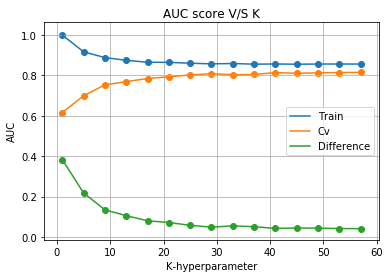

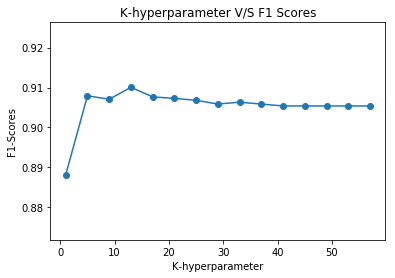

Best value of K is:  57


In [34]:
best_K_bow = KNN(bow_train, bow_cv, train['Score'], cv['Score'])

In [35]:
test['Score'].value_counts()

1    1253
0     243
Name: Score, dtype: int64

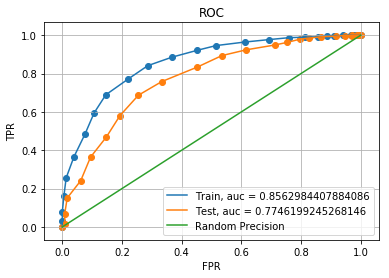

Accuracy score of Test Data is : 83.82352941176471


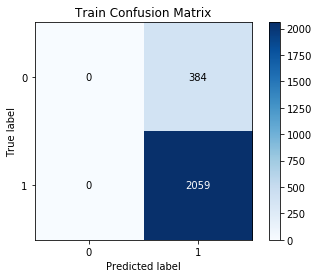

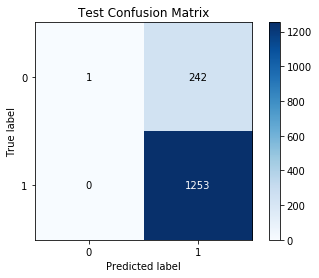

AUC of Test Data 77.46199245268146


In [36]:
# Testing mdoel on Test Data
auc_bow = KNN(bow_train, bow_test, train['Score'], test['Score'], find_K=False,K=best_K_bow)
print("AUC of Test Data" ,auc_bow*100)

#### [5.0.1.2] KNN on n-grams

In [37]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
# you can choose these numebrs min_df=10, max_features=5000, of your choice

# max_features https://stackoverflow.com/questions/46118910/scikit-learn-vectorizer-max-features
# max_features only select those number of features that occur the most.
# For eg here, select the top 5000 features that occur the most in corpus.
#min_df(document frequency) and max_df explained  https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
#Here min_df means ignore the word if it appers less than 10 documents
#You can also give min_df in float, in float the value is considered as percentage
#For eg:- min_df = 0.10, Then Ignore the feature if it appears in less than 10% of documents

n_gram_bow = CountVectorizer(ngram_range=(1,2), min_df=5) #ngrams_range(lower,upper)
# ngram_range  https://www.kaggle.com/c/avito-demand-prediction/discussion/58819
# In ngrams_range we give range of lower_gram and upper_gram
# The function will return matrix of grams from lower_gram to upper_gram
# for example ngrams_range(1,3)  ---> return matrix of uni,bi,tri grams

n_gram_bow = n_gram_bow.fit(train['Text'])

n_gram_bow_train = n_gram_bow.transform(train['Text'])
n_gram_bow_cv = n_gram_bow.transform(cv['Text'])
n_gram_bow_test = n_gram_bow.transform(test['Text'])

n_gram_bow_train = Normalizer().fit_transform(bow_train)
n_gram_bow_cv = Normalizer().fit_transform(bow_cv)
n_gram_bow_test = Normalizer().fit_transform(bow_test)


print("the type of count vectorizer ",type(bow_train))
print("the shape of our train text BOW ",bow_train.shape)
print("the number of unique words including both unigrams and bigrams ", bow_train.shape[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of our train text BOW  (2443, 6567)
the number of unique words including both unigrams and bigrams  6567


k = 1 ------> 0.616341086853891
k = 5 ------> 0.6951437357253135
k = 9 ------> 0.7529091651461601
k = 13 ------> 0.7694933204037104
k = 17 ------> 0.7822496267847344
k = 21 ------> 0.7930377808684113
k = 25 ------> 0.8039726691590217
k = 29 ------> 0.8079855307312468
k = 33 ------> 0.8032772766131193
k = 37 ------> 0.806176872137088
k = 41 ------> 0.813379607773085
k = 45 ------> 0.8100621387467623
k = 49 ------> 0.8133796077730853
k = 53 ------> 0.8127862911972235
k = 57 ------> 0.8143780383550457


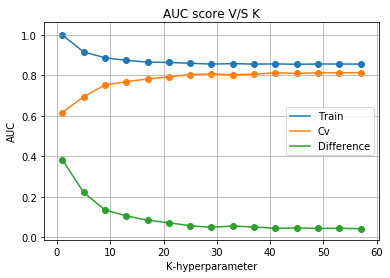

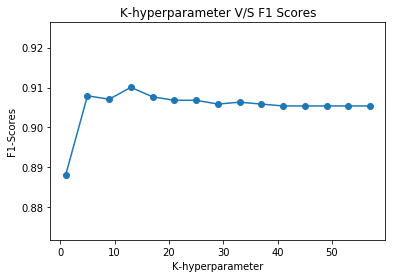

Best value of K is:  57


In [38]:
n_gram_best_K_bow = KNN(n_gram_bow_train, n_gram_bow_cv, train['Score'], cv['Score'])

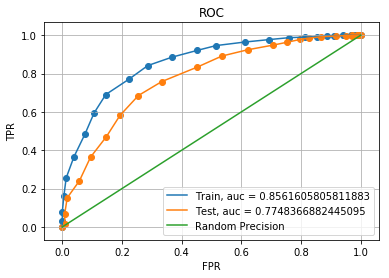

Accuracy score of Test Data is : 83.82352941176471


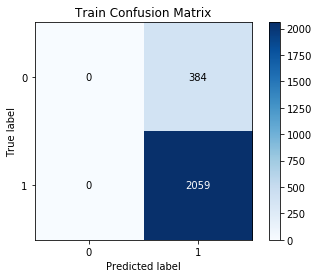

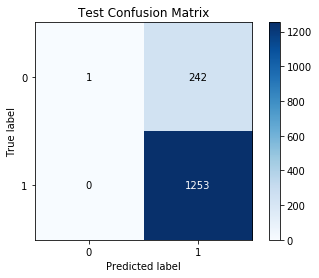

AUC of Test Data 77.46199245268146


In [39]:
n_gram_auc_bow = KNN(n_gram_bow_train, n_gram_bow_test, train['Score'], test['Score'], find_K=False,K=n_gram_best_K_bow)
print("AUC of Test Data" ,auc_bow*100)

### [5.0.2] KNN on tf-IDF

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df=5)
tfidf = tfidf.fit(train['Text'])
print(tfidf.get_feature_names()[100:110])

tfidf_train = tfidf.transform(train['Text'])
tfidf_cv = tfidf.transform(cv['Text'])
tfidf_test = tfidf.transform(test['Text'])

tfidf_train = Normalizer().fit_transform(tfidf_train)
tfidf_cv = Normalizer().fit_transform(tfidf_cv)
tfidf_test = Normalizer().fit_transform(tfidf_test)

print("="*50,"\nthe type of count vectorizer ",type(tfidf))
print("the shape of our train tf-idf vector ",tfidf_train.shape)
print("the number of unique words including both unigrams and bigrams ", tfidf_train.shape[1])

['awar', 'away', 'awesom', 'babi', 'back', 'bacon', 'bad', 'bag', 'bake', 'baker']
the type of count vectorizer  <class 'sklearn.feature_extraction.text.TfidfVectorizer'>
the shape of our train tf-idf vector  (2443, 1919)
the number of unique words including both unigrams and bigrams  1919


k = 1 ------> 0.5931666517805877
k = 5 ------> 0.7150007017722941
k = 9 ------> 0.7355052122542202
k = 13 ------> 0.7647627371671365
k = 17 ------> 0.7644884079976523
k = 21 ------> 0.7611581794750744
k = 25 ------> 0.7712796498794227
k = 29 ------> 0.7753020810738391
k = 33 ------> 0.7809832467814171
k = 37 ------> 0.7972866931213556
k = 41 ------> 0.7949612749288658
k = 45 ------> 0.8002787949931737
k = 49 ------> 0.8000299848161995
k = 53 ------> 0.8034750488050733
k = 57 ------> 0.8086968726474678


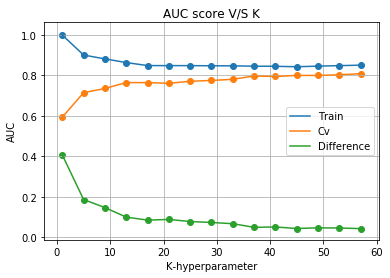

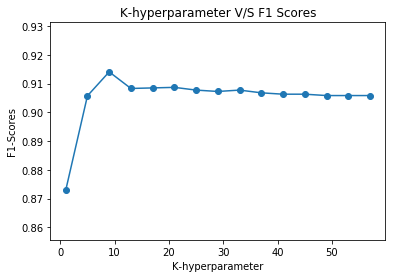

Best value of K is:  57


In [41]:
best_K_tfidf = KNN(tfidf_train, tfidf_cv, train['Score'], cv['Score'])

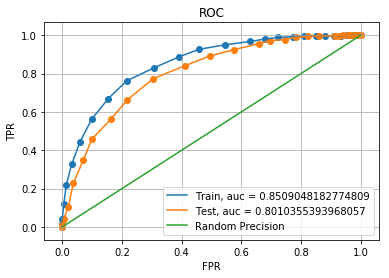

Accuracy score of Test Data is : 83.82352941176471


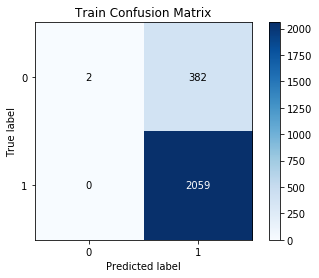

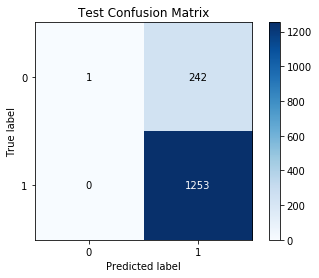

AUC of Test Data 77.46199245268146


In [42]:
auc_tfidf = KNN(tfidf_train, tfidf_test, train['Score'], test['Score'], find_K=False,K=best_K_tfidf)
print("AUC of Test Data" ,auc_bow*100)

## Word2Vector

__Word2Vector is an algorithm made by google that gives you a numeric vector corresponding to the word you give the algorithm as input, This vector can be used to find similarity between the words and can group together similar words. Although we can use this algo on our review dataset, google has provided us with it's own dataset, each word have 300 dimensions vector and the weights are trained on GoogleNews.__

In [43]:
# If we want to use w2v we need to convert our data to tokens i.e. list of list.
# Here each ducument will be a list whose words are element of the list.
# All the documents will be contained in a bigger list i.e. Corpous
corpus=[]
for document in preprocessed_review:
    corpus.append(document.split(' '))
    
print(corpus[10])
print(len(corpus))

['bought', 'brand', 'onlin', 'indian', 'groceri', 'store', 'usual', 'excel', 'product', 'abl', 'turn', 'cream', 'butter', 'use', 'super', 'blender', 'ad', 'water', 'bare', 'flavor', 'usual', 'buy', 'chao', 'kah', 'brand', 'coconut', 'cream', 'quit', 'tasti', 'flavor', 'read', 'anoth', 'review', 'differ', 'product', 'make', 'coconut', 'cream', 'complaint', 'shred', 'textur', 'mine', 'virtual', 'tasteless']
4986


In [44]:
# Here is a really good article on Word2Vector
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.XR0cft9fiXJ
from gensim.models import Word2Vec  

model = Word2Vec(corpus,size=150,window=10,min_count=5,workers=4)
# size is number of dimensions of vector that you want to build
# window is the maximum distance between two similar words
# min_count is the minimum number of times the word must appear in corpus
# workers is the numbers of cpu that you want to use

# Read the above article to know about these arguments if full detail

In [45]:
print(model.wv.most_similar('bad',topn=15)) #topn specifes number of examples in output.

[('probabl', 0.999360203742981), ('aw', 0.9993414878845215), ('might', 0.9990948438644409), ('snap', 0.9989598989486694), ('wow', 0.9989594221115112), ('mark', 0.998927116394043), ('oh', 0.9989023804664612), ('kernel', 0.9988421201705933), ('worst', 0.9988225102424622), ('brother', 0.9988028407096863), ('though', 0.9988011717796326), ('munch', 0.9987984895706177), ('gum', 0.9987707138061523), ('expect', 0.9987587928771973), ('movi', 0.9987014532089233)]


In [46]:
print(model.wv.most_similar('good'))
print('\n')
print(model.wv.similarity('good','tasti'))
print('\n')
print(model.wv.most_similar('smell'))

[('subtl', 0.9967703223228455), ('better', 0.9959726929664612), ('slight', 0.9958289861679077), ('prefer', 0.9957625865936279), ('creami', 0.9957456588745117), ('far', 0.9956265091896057), ('hint', 0.9954854249954224), ('overpow', 0.9954385757446289), ('honey', 0.9953733682632446), ('richer', 0.9953432083129883)]


0.99187076


[('leav', 0.9990697503089905), ('sunset', 0.9990413188934326), ('melitta', 0.9987791180610657), ('wateri', 0.9987516403198242), ('caffein', 0.998704195022583), ('riviera', 0.9986799955368042), ('french', 0.9986622333526611), ('starbuck', 0.998600959777832), ('decaffein', 0.9985030889511108), ('habit', 0.9984818696975708)]


In [47]:
print(len(model.wv.vocab)) # Total number of words in our vocabulary
print(type(model.wv.vocab))
print("Some words :",list(model.wv.vocab)[1000:1010])
vocabulary = model.wv.vocab

2989
<class 'dict'>
Some words : ['close', 'proper', 'side', 'air', 'oxid', 'import', 'stale', 'rancid', 'human', 'post']


> **Remember, More the data better the Word2Vec perfroms.**<br>
__Here Word2Vec will not perform very well as data in less__

### [5.0.3] KNN on Average W2V

In [53]:
# Compute Average Word2Vector
def aw2v(data):
    avg_list = []
    for review in tqdm(data):
        vec = np.zeros(150)
        count=0
        for word in review.split(' '):
            try:
                vec += model.wv[word]
                count+=1
            except:
                pass
        if count != 0:
            vec =vec/count
            avg_list.append(vec)
        else:
            avg_list.append(np.zeros(150))
            
            
    print("Total number of the vector : ",len(avg_list))  #Length of the list
    print("Dimension of Vector : ",len(avg_list[1])) # Length of average vector
    return np.array(avg_list)

In [54]:
aw2v_train = aw2v(train['Text'])
aw2v_cv = aw2v(cv['Text'])
aw2v_test = aw2v(test['Text'])

# Normalizing Data
aw2v_train = Normalizer().fit_transform(aw2v_train)
aw2v_cv = Normalizer().fit_transform(aw2v_cv)
aw2v_test = Normalizer().fit_transform(aw2v_test)

  0%|          | 0/1496 [00:00<?, ?it/s]

Total number of the vector :  2443
Dimension of Vector :  150
Total number of the vector :  1047
Dimension of Vector :  150


100%|██████████| 1496/1496 [00:00<00:00, 6314.12it/s]

Total number of the vector :  1496
Dimension of Vector :  150


k = 1 ------> 0.5370918556135404
k = 5 ------> 0.5871696885406963
k = 9 ------> 0.5941491329922295
k = 13 ------> 0.6295152667372692
k = 17 ------> 0.6087970346930703
k = 21 ------> 0.6153107575312926
k = 25 ------> 0.6183156188993658
k = 29 ------> 0.6271866586707158
k = 33 ------> 0.639043420565756
k = 37 ------> 0.6276810891506004
k = 41 ------> 0.6205357712477511
k = 45 ------> 0.6135276179296442
k = 49 ------> 0.6141560231202072
k = 53 ------> 0.6146919219629209
k = 57 ------> 0.6154830107307363


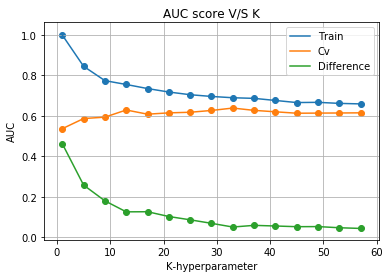

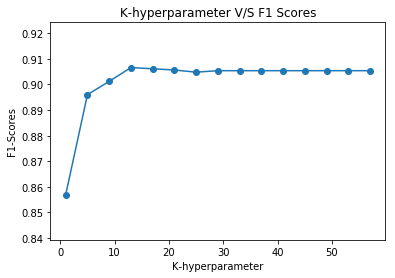

Best value of K is:  33


In [55]:
best_K_avg_w2v = KNN(aw2v_train, aw2v_cv, train['Score'], cv['Score'])

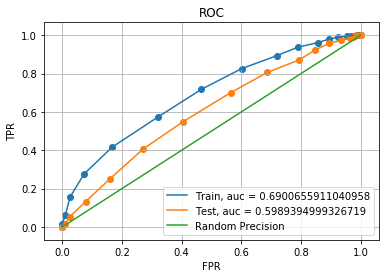

Accuracy score of Test Data is : 83.8903743315508


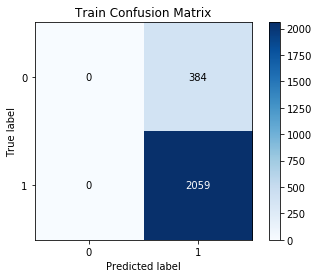

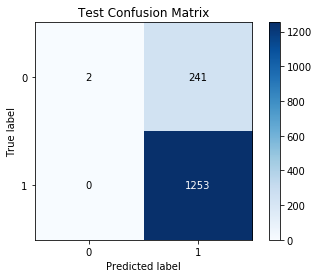

AUC of Test Data 59.89394999326719


In [56]:
auc_avg_w2v = KNN(aw2v_train, aw2v_test, train['Score'], test['Score'], find_K=False,K=best_K_avg_w2v)
print("AUC of Test Data" ,auc_avg_w2v*100)

### [5.0.4] KNN on TFIDF weighted W2v

In [57]:
vocabulary_tfidf = tfidf.get_feature_names()

In [58]:
def tfidf_w_w2v(data, train_data=False, cv_data=False, test_data=False):
    if train_data==True:
        tfidf_data=tfidf_train
    elif cv_data==True:
        tfidf_data=tfidf_cv
    elif test_data==True:
        tfidf_data=tfidf_test
    else:
        print("All parameters are False!")
        return
    row, counter=0,0
    tfidf_w_w2v_list = []
    for sentence in tqdm(data):
        cnt_words=0.0
        weighted_tfidf = np.zeros(150)
        for word in sentence.split(' '):
            try:
                vec = model.wv[word]
                tfidf_ = tfidf_data[row,vocabulary_tfidf.index(word)]
                weighted_tfidf += tfidf_*vec
                cnt_words+=tfidf_
            except:
                pass
        if cnt_words !=0:
            tfidf_w_w2v_list.append(weighted_tfidf/cnt_words)
        else:
            tfidf_w_w2v_list.append(np.zeros(150))
            counter+=1
        row +=1
    print("Total Number of Null review : ", counter)
    return np.array(tfidf_w_w2v_list)

In [59]:
tfidf_w_w2v_train = tfidf_w_w2v(train['Text'], train_data=True)
tfidf_w_w2v_cv = tfidf_w_w2v(cv['Text'], cv_data=True)
tfidf_w_w2v_test = tfidf_w_w2v(test['Text'], test_data=True)

# Normalizing Data
tfidf_w_w2v_train = Normalizer().fit_transform(tfidf_w_w2v_train)
tfidf_w_w2v_cv = Normalizer().fit_transform(tfidf_w_w2v_cv)
tfidf_w_w2v_test = Normalizer().fit_transform(tfidf_w_w2v_test)

  5%|▌         | 56/1047 [00:00<00:01, 556.54it/s]

Total Number of Null review :  9


  4%|▍         | 64/1496 [00:00<00:02, 639.00it/s]

Total Number of Null review :  1


100%|██████████| 1496/1496 [00:02<00:00, 567.42it/s]

Total Number of Null review :  5


In [60]:
print("Shape of tfidf_w_w2v_train : ", tfidf_w_w2v_train.shape, "\nShape of tfidf_w_w2v_cv : ", tfidf_w_w2v_cv.shape, "\nShape of tfidf_w_w2v_test : ", tfidf_w_w2v_test.shape)

Shape of tfidf_w_w2v_train :  (2443, 150) 
Shape of tfidf_w_w2v_cv :  (1047, 150) 
Shape of tfidf_w_w2v_test :  (1496, 150)


k = 1 ------> 0.5195666875071773
k = 5 ------> 0.588490296403098
k = 9 ------> 0.5916195628596583
k = 13 ------> 0.591415410919577
k = 17 ------> 0.5976611843364424
k = 21 ------> 0.6013327293838439
k = 25 ------> 0.5935462467941767
k = 29 ------> 0.5927742972707438
k = 33 ------> 0.592436170619984
k = 37 ------> 0.6003693874165847
k = 41 ------> 0.5945095887614357
k = 45 ------> 0.5906849297589731
k = 49 ------> 0.5785602184425759
k = 53 ------> 0.5800307503859747
k = 57 ------> 0.5868475112602555


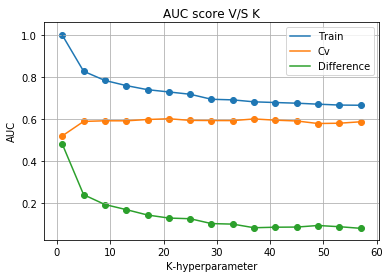

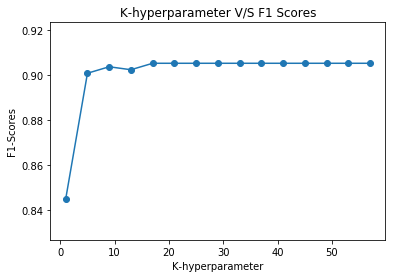

Best value of K is:  21


In [61]:
best_K_tfidf_w_w2v = KNN(tfidf_w_w2v_train, tfidf_w_w2v_cv, train['Score'], cv['Score'])

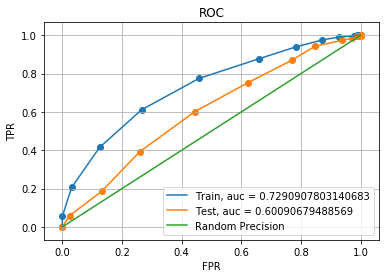

Accuracy score of Test Data is : 83.62299465240642


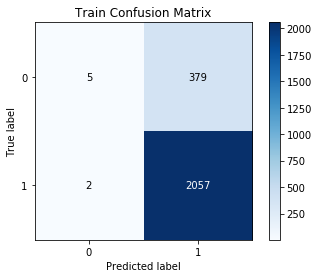

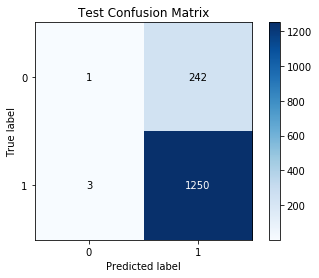

AUC of Test Data 60.090679488569


In [62]:
auc_tfidf_w_w2v = KNN(tfidf_w_w2v_train, tfidf_w_w2v_test, train['Score'], test['Score'], find_K=False,K=best_K_tfidf_w_w2v)
print("AUC of Test Data" ,auc_tfidf_w_w2v*100)

## [6.0.1] KNN using kd-Tree

### [6.0.1.1] KNN on BOW using kd-Tree

k = 1 ------> 0.5052760517014789
k = 5 ------> 0.5117387365546808
k = 9 ------> 0.5140290661324691
k = 13 ------> 0.694773710333916
k = 17 ------> 0.7457128092582904
k = 21 ------> 0.7655155474461869
k = 25 ------> 0.7820709938371632
k = 29 ------> 0.7981288198741913
k = 33 ------> 0.796846490500555
k = 37 ------> 0.8018226940400393
k = 41 ------> 0.8071912520893676
k = 45 ------> 0.8084353029742386
k = 49 ------> 0.8109074553736617
k = 53 ------> 0.8106076072116671
k = 57 ------> 0.8105693287229021


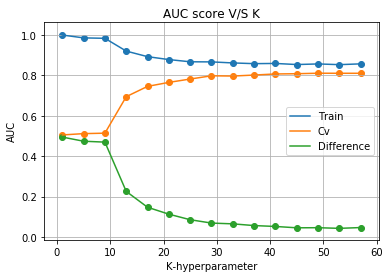

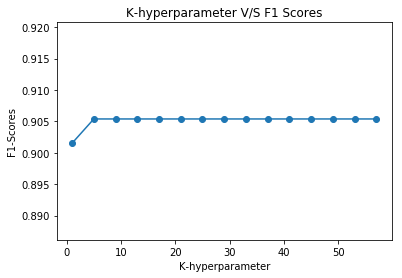

Best value of K is:  49


In [63]:
tree_best_K_bow = KNN(bow_train.todense(), bow_cv.todense(), train['Score'], cv['Score'], algo='kd_tree',metrics='minkowski')

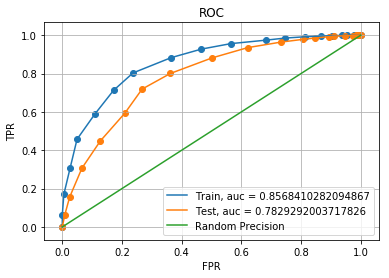

Accuracy score of Test Data is : 83.7566844919786


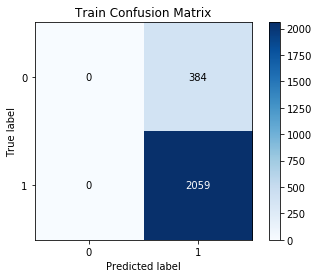

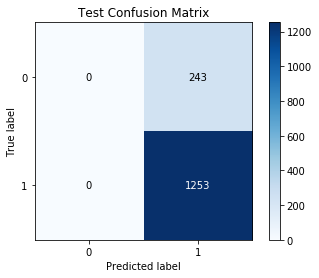

AUC of Test Data 77.46199245268146


In [65]:
# Testing mdoel on Test Data
tree_auc_bow = KNN(bow_train.todense(), bow_test.todense(), train['Score'], test['Score'], find_K=False,K=tree_best_K_bow, algo='kd_tree',metrics='minkowski')
print("AUC of Test Data" ,auc_bow*100)

### [6.0.2] KNN on tf-IDF

k = 1 ------> 0.5064307861125643
k = 5 ------> 0.5102363058706443
k = 9 ------> 0.5102363058706443
k = 13 ------> 0.6892552282035905
k = 17 ------> 0.7400954410319881
k = 21 ------> 0.7546093680221505
k = 25 ------> 0.7734487642427876
k = 29 ------> 0.7603415717147486
k = 33 ------> 0.7678569150089953
k = 37 ------> 0.7748491189567835
k = 41 ------> 0.7768683092391512
k = 45 ------> 0.7961223890880789
k = 49 ------> 0.7983584908067829
k = 53 ------> 0.7990730225970678
k = 57 ------> 0.7991049213377055


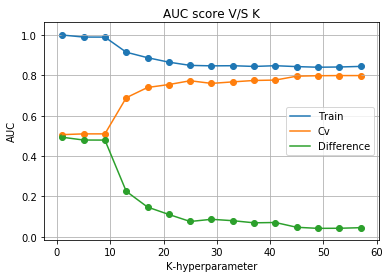

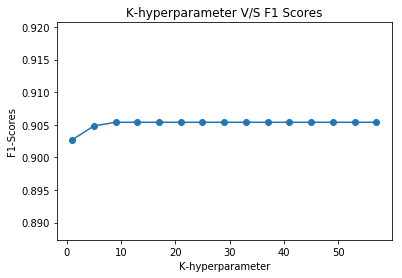

Best value of K is:  57


In [67]:
tree_best_K_tfidf = KNN(tfidf_train.todense(), tfidf_cv.todense(), train['Score'], cv['Score'],algo='kd_tree',metrics='minkowski')

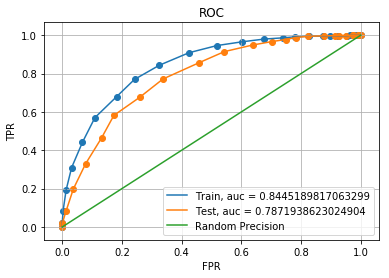

Accuracy score of Test Data is : 83.7566844919786


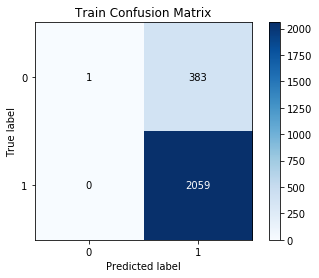

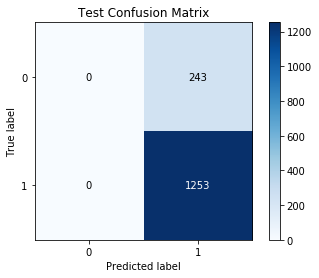

AUC of Test Data 78.71938623024904


In [68]:
tree_auc_tfidf = KNN(tfidf_train.todense(), tfidf_test.todense(), train['Score'], test['Score'], find_K=False,K=tree_best_K_tfidf,algo='kd_tree',metrics='minkowski')
print("AUC of Test Data" ,tree_auc_tfidf*100)

### [6.0.3] KNN on Average W2V

k = 1 ------> 0.5370918556135404
k = 5 ------> 0.5871696885406963
k = 9 ------> 0.5941491329922295
k = 13 ------> 0.6295152667372692
k = 17 ------> 0.6087970346930703
k = 21 ------> 0.6153107575312926
k = 25 ------> 0.6183156188993658
k = 29 ------> 0.6271866586707158
k = 33 ------> 0.639043420565756
k = 37 ------> 0.6276810891506004
k = 41 ------> 0.6205357712477511
k = 45 ------> 0.6135276179296442
k = 49 ------> 0.6141560231202072
k = 53 ------> 0.6146919219629209
k = 57 ------> 0.6154830107307363


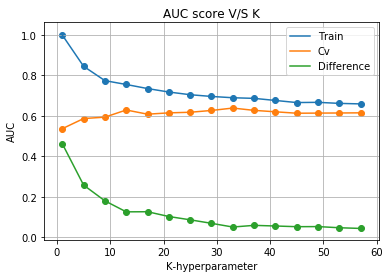

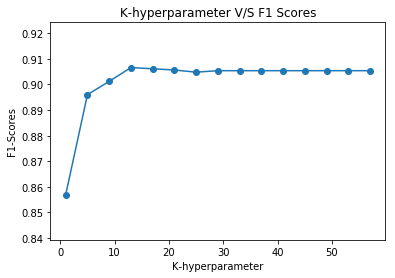

Best value of K is:  33


In [70]:
tree_best_K_avg_w2v = KNN(aw2v_train, aw2v_cv, train['Score'], cv['Score'],algo='kd_tree',metrics='minkowski')

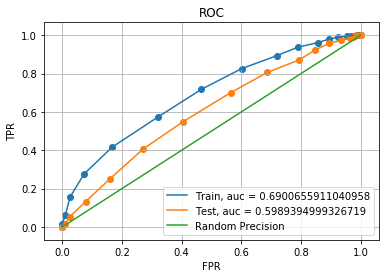

Accuracy score of Test Data is : 83.8903743315508


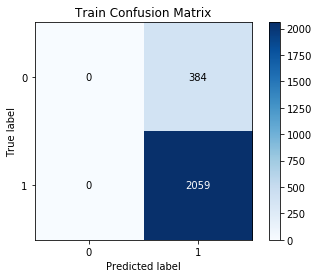

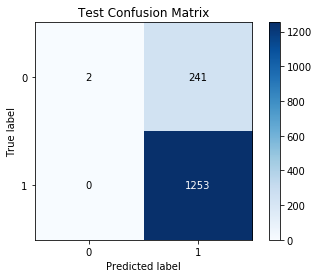

AUC of Test Data 59.89394999326719


In [71]:
tree_auc_avg_w2v = KNN(aw2v_train, aw2v_test, train['Score'], test['Score'], find_K=False,K=tree_best_K_avg_w2v,algo='kd_tree',metrics='minkowski')
print("AUC of Test Data" ,tree_auc_avg_w2v*100)

### [5.0.4] KNN on TFIDF weighted W2v

k = 1 ------> 0.5195666875071773
k = 5 ------> 0.5892494864302757
k = 9 ------> 0.5922575376724127
k = 13 ------> 0.5916993097112526
k = 17 ------> 0.598171564186646
k = 21 ------> 0.6017920712490271
k = 25 ------> 0.5939513608002757
k = 29 ------> 0.5931634619065239
k = 33 ------> 0.5925924744491088
k = 37 ------> 0.6003693874165847
k = 41 ------> 0.5943564748063747
k = 45 ------> 0.5906849297589731
k = 49 ------> 0.5782858892730915
k = 53 ------> 0.5799222946678065
k = 57 ------> 0.5867645745345974


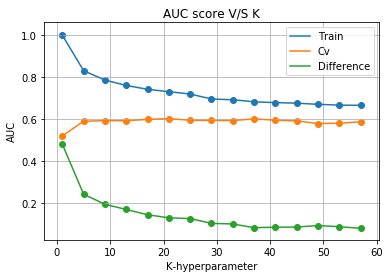

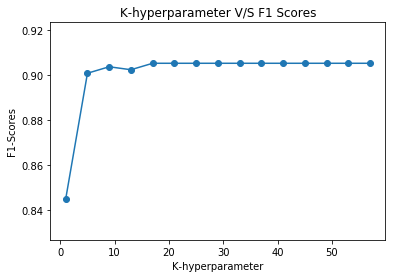

Best value of K is:  21


In [72]:
tree_best_K_tfidf_w_w2v = KNN(tfidf_w_w2v_train, tfidf_w_w2v_cv, train['Score'], cv['Score'],algo='kd_tree',metrics='minkowski')

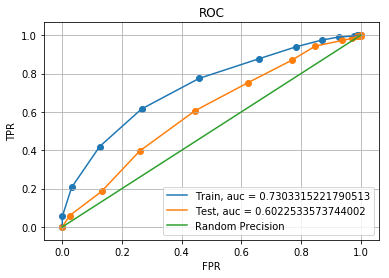

Accuracy score of Test Data is : 83.62299465240642


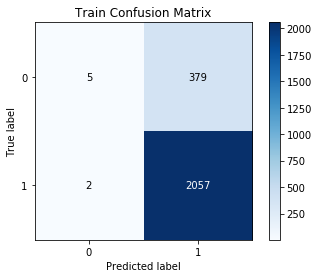

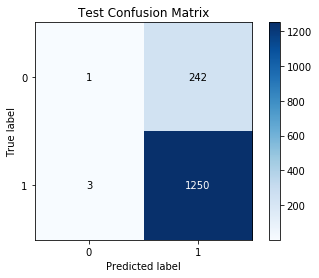

AUC of Test Data 60.22533573744002


In [74]:
tree_auc_tfidf_w_w2v = KNN(tfidf_w_w2v_train, tfidf_w_w2v_test, train['Score'], test['Score'], find_K=False,K=tree_best_K_tfidf_w_w2v,algo='kd_tree',metrics='minkowski')
print("AUC of Test Data" ,tree_auc_tfidf_w_w2v*100)

# [7.0] Conclusion

In [77]:
# Now we need to draw PrettyTable of all of the above conclusions
from prettytable import PrettyTable
p_table = PrettyTable()
p_table.field_names = ['Vectorizer', 'Model', 'Hyper Parameter', 'AUC']
p_table.add_row(['BOW',' Dumb Model', 1617, dumb_auc_test])
p_table.add_row(['BOW',' Brute n grams', n_gram_best_K_bow, n_gram_auc_bow])
p_table.add_row(['BOW',' Brute', best_K_bow, auc_bow])
p_table.add_row(['TFIDF', 'Brute', best_K_tfidf, auc_tfidf])
p_table.add_row(['Average W2V', 'Brute', best_K_avg_w2v, auc_avg_w2v])
p_table.add_row(['TFIDF W2V','Brute', best_K_tfidf_w_w2v, auc_tfidf_w_w2v])
# kd-tree
p_table.add_row(['BOW',' kd-tree', tree_best_K_bow, tree_auc_bow])
p_table.add_row(['TFIDF', 'kd-tree', tree_best_K_tfidf, tree_auc_tfidf])
p_table.add_row(['Average W2V', 'kd-tree', tree_best_K_avg_w2v, tree_auc_avg_w2v])
p_table.add_row(['TFIDF W2V','kd-tree', tree_best_K_tfidf_w_w2v, tree_auc_tfidf_w_w2v])
print(p_table)
print("I have used only 5k data points using more data points will significantly improve the Performace of this model")

+-------------+----------------+-----------------+--------------------+
|  Vectorizer |     Model      | Hyper Parameter |        AUC         |
+-------------+----------------+-----------------+--------------------+
|     BOW     |   Dumb Model   |       1617      | 0.7944197402880839 |
|     BOW     |  Brute n grams |        57       | 0.7748366882445095 |
|     BOW     |      Brute     |        57       | 0.7746199245268146 |
|    TFIDF    |     Brute      |        57       | 0.8010355393968057 |
| Average W2V |     Brute      |        33       | 0.5989394999326719 |
|  TFIDF W2V  |     Brute      |        21       |  0.60090679488569  |
|     BOW     |     kd-tree    |        49       | 0.7829292003717826 |
|    TFIDF    |    kd-tree     |        57       | 0.7871938623024904 |
| Average W2V |    kd-tree     |        33       | 0.5989394999326719 |
|  TFIDF W2V  |    kd-tree     |        21       | 0.6022533573744002 |
+-------------+----------------+-----------------+--------------